In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error
from keras.layers import Input

In [2]:
# First, we get the data
df = pd.read_csv('apple_stock.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.318729,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.938305,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.030676,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.908880,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,17.015959,258529600


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-25,171.880005,173.059998,170.649994,171.100006,170.874893,57157000
2023-10-26,170.369995,171.380005,165.669998,166.889999,166.670425,70625300
2023-10-27,166.910004,168.960007,166.830002,168.220001,167.998672,58499100
2023-10-30,169.020004,171.169998,168.869995,170.289993,170.065933,51131000
2023-10-31,169.350006,170.899994,167.899994,170.770004,170.545319,44846000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2475 entries, 2014-01-02 to 2023-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2475 non-null   float64
 1   High       2475 non-null   float64
 2   Low        2475 non-null   float64
 3   Close      2475 non-null   float64
 4   Adj Close  2475 non-null   float64
 5   Volume     2475 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 135.4 KB


In [5]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2.475000e+03
mean,76.004968,76.845661,75.213720,76.064199,74.097124,1.380565e+08
std,54.739063,55.389713,54.134658,54.787600,55.248195,8.399674e+07
min,17.684999,17.911785,17.626785,17.849285,15.648315,3.145820e+07
25%,29.592500,29.841249,29.371249,29.707500,27.131330,8.300500e+07
50%,47.507500,47.967499,47.267502,47.599998,45.507229,1.134760e+08
75%,132.145004,133.680000,130.495003,132.029999,130.403320,1.682138e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


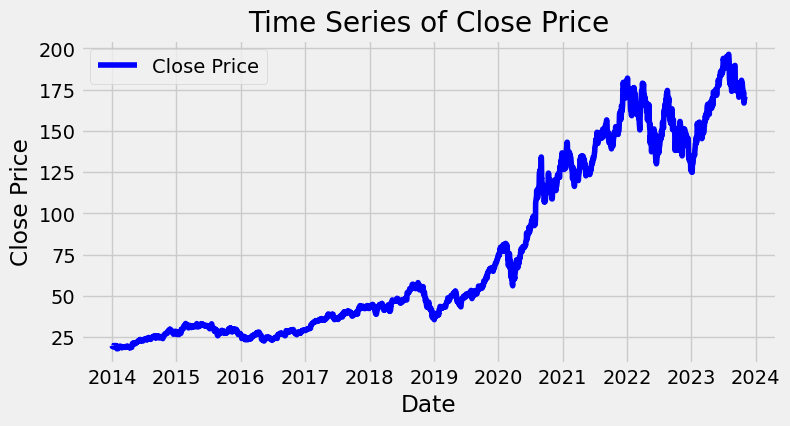

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [9]:
# Some functions to help out with this code
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Apple Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Aplle Stock Price')
    plt.title('Apple Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Apple Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [10]:
# Checking for missing values
training_set = df[:'2022'].iloc[:,1:2].values
test_set = df['2023':].iloc[:,1:2].values

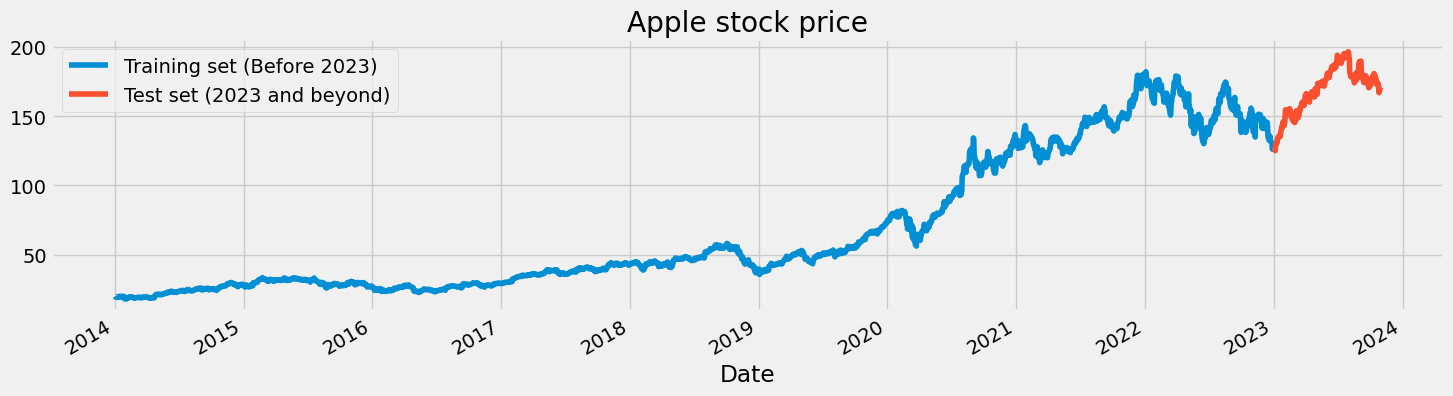

In [11]:
df["Close"][:'2022'].plot(figsize=(16,4),legend=True)
df["Close"]['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2023)','Test set (2023 and beyond)'])
plt.title('Apple stock price')
plt.show()

In [12]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [13]:
training_set_scaled.shape

(2266, 1)

In [14]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2266):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [16]:
# The LSTM architecture
model_lstm = Sequential()
# First LSTM layer with Dropout regularisation
model_lstm.add(Input(shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Second LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Third LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Fourth LSTM layer
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
# The output layer
model_lstm.add(Dense(units=1))

# Compiling the RNN
model_lstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
model_lstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 0.0280
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0063
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0061
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0042
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0044
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0046
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0032
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.0033
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0030
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0032
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0034
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0028
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0028
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0027
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - los

In [17]:
dataset_total = pd.concat((df["Close"][:'2022'],df["Close"]['2023':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [18]:
inputs.shape

(269, 1)

In [19]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,269):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step


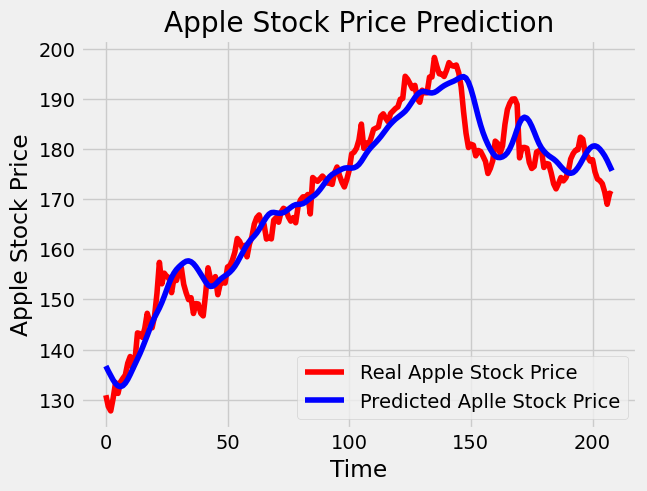

In [20]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [21]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.264226605861584.


In [51]:
# The GRU architecture
LSTM_GRU = Sequential()
# First GRU layer with Dropout regularisation
LSTM_GRU.add(Input(shape=(X_train.shape[1], 1)))
LSTM_GRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Second GRU layer
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Third GRU layer
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Fourth GRU layer
LSTM_GRU.add(GRU(units=50, activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# The output layer
LSTM_GRU.add(Dense(units=1))
# Compiling the RNN
LSTM_GRU.compile(SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
LSTM_GRU.fit(X_train,y_train,epochs=100,batch_size=150)

C:\Users\sucir\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - loss: 0.1234
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0563
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0154
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 0.0052
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 0.0038
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - loss: 0.0035
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 0.0030
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0032
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.0037
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.0030
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0031
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0028
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - loss: 0.0027
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 0.0028
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s

In [52]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,269):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = LSTM_GRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step


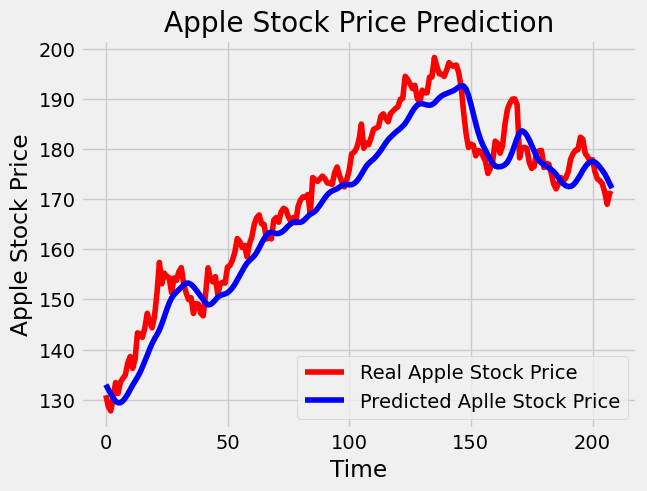

In [53]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [54]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 4.891061011508477.
